In [15]:
# Let's try a more direct approach to get Form 4 filing details
# We'll use the SEC EDGAR website directly

import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import re
from datetime import datetime

tesla_cik = "0001318605"
headers = {'User-Agent': 'example@example.com'}


# Function to get Form 4 filings from SEC EDGAR website
def get_form4_filings_from_sec(cik, year):
    
    cik_formatted = cik.zfill(10)
    url = f"https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK={cik}&type=4&dateb=&owner=include&count=100"
        
    try:
        response = requests.get(url, headers=headers)
        soup = BeautifulSoup(response.text, 'html.parser')
        table = soup.find('table', class_='tableFile2')
        
        if not table:
            return pd.DataFrame()
        
        filings = []
        for row in table.find_all('tr')[1:]:  # Skip header row
            cols = row.find_all('td')
            
            if len(cols) >= 5:
                filing_type = cols[0].text.strip()
                
                if filing_type == '4':
                    filing_date = cols[3].text.strip()
                    
                    # Check if filing is from the current year
                    if filing_date.startswith(str(year)):
                        filing_link = cols[1].find('a')['href'] if cols[1].find('a') else None
                        
                        if filing_link:
                            if filing_link.startswith('/'):
                                filing_link = f"https://www.sec.gov{filing_link}"
                            
                            filings.append({
                                'form': filing_type,
                                'filing_date': filing_date,
                                'filing_link': filing_link
                            })
        
        return pd.DataFrame(filings)
    
    except Exception as e:
        print(f"Error getting filings from SEC: {e}")
        return pd.DataFrame()

# Function to extract Form 4 details from filing page
def extract_form4_details(filing_link):
        
    try:
        response = requests.get(filing_link, headers=headers)
        soup = BeautifulSoup(response.text, 'html.parser')
        form4_link = None
        
        for table in soup.find_all('table'):
            for row in table.find_all('tr'):
                cols = row.find_all('td')
                
                for col in cols:
                    if col.find('a') and 'form4' in col.text.lower():
                        form4_link = col.find('a')['href']
                        
                        # Format the link
                        if form4_link.startswith('/'):
                            form4_link = f"https://www.sec.gov{form4_link}"
                        
                        break
        
        if not form4_link:
            # Try to find XML file
            for table in soup.find_all('table'):
                for row in table.find_all('tr'):
                    cols = row.find_all('td')
                    
                    for col in cols:
                        if col.find('a') and col.find('a')['href'].endswith('.xml'):
                            form4_link = col.find('a')['href']
                            
                            # Format the link
                            if form4_link.startswith('/'):
                                form4_link = f"https://www.sec.gov{form4_link}"
                            
                            break
        
        if not form4_link:
            return None
        
        # Get the Form 4 document
        response = requests.get(form4_link, headers=headers)
        
        # Extract filing details
        details = {}
        
        
        xml_soup = BeautifulSoup(response.text, 'xml')
        
        # Get reporting person
        reporting_owner = xml_soup.find('reportingOwner')
        if reporting_owner:
            owner_name = reporting_owner.find('rptOwnerName')
            if owner_name:
                details['reporting_person'] = owner_name.text
        
        # Get transaction details
        transactions = []
            
        non_derivative_table = xml_soup.find('nonDerivativeTable')
        if non_derivative_table:
            for transaction in non_derivative_table.find_all('nonDerivativeTransaction'):
                trans_details = {}
                
                # Security title
                security = transaction.find('securityTitle')
                if security and security.find('value'):
                    trans_details['security'] = security.find('value').text
                
                # Transaction date
                date = transaction.find('transactionDate')
                if date and date.find('value'):
                    trans_details['date'] = date.find('value').text
                
                # Transaction code
                code = transaction.find('transactionCode')
                if code:
                    trans_details['code'] = code.text
                
                # Transaction shares
                shares = transaction.find('transactionShares')
                if shares and shares.find('value'):
                    trans_details['shares'] = shares.find('value').text
                    
                # Transaction price
                price = transaction.find('transactionPricePerShare')
                if price and price.find('value'):
                    trans_details['price'] = price.find('value').text
                
                transactions.append(trans_details)
        
        details['transactions'] = transactions
        
        return details
        
    except Exception as e:
        print(f"Error extracting Form 4 details: {e}")
        return None
    
# function to get filings, extract details, merge, and save to csv
def get_and_merge_form4_filings(cik, year):
    form4_filings = get_form4_filings_from_sec(cik, year)

    if form4_filings.empty:
        print(f"No Form 4 filings found for Tesla in {year}")

    else:
        
        filing_details = []
        transaction_details = []
        
        # Process each Form 4 filing 
        num_filings = len(form4_filings)
        for i, (_, filing) in enumerate(form4_filings.head(num_filings).iterrows()):
            details = extract_form4_details(filing['filing_link'])
            
            if details:
                # Add filing details
                filing_detail = {
                    'filing_date': filing['filing_date'],
                    'filing_link': filing['filing_link'],
                    'reporting_person': details.get('reporting_person', 'Unknown')
                }
                filing_details.append(filing_detail)
                
                # Add transaction details
                for transaction in details.get('transactions', []):
                    transaction_detail = {
                        'filing_date': filing['filing_date'],
                        'reporting_person': details.get('reporting_person', 'Unknown'),
                        'security': transaction.get('security', ''),
                        'transaction_date': transaction.get('date', ''),
                        'transaction_code': transaction.get('code', ''),
                        'shares': transaction.get('shares', ''),
                        'price_per_share': transaction.get('price', '')
                    }
                    transaction_details.append(transaction_detail)
            
            # Be nice to SEC servers
            time.sleep(1)
        
        # Convert to DataFrames
        filing_details_df = pd.DataFrame(filing_details)
        transaction_details_df = pd.DataFrame(transaction_details)
        transaction_details_df['dollar_value'] = (
            transaction_details_df['shares'].astype(float) 
            * transaction_details_df['price_per_share'].astype(float)
        )
            
        return form4_filings, filing_details_df, transaction_details_df
 
        

In [ ]:
filings_2024, details_2024, transactions_2024 = get_and_merge_form4_filings(tesla_cik, 2024)
filings_2025, details_2025, transactions_2025 = get_and_merge_form4_filings(tesla_cik, 2025)

In [17]:
transactions_2024 = transactions_2024[transactions_2024.filing_date <= "2024-03-31"]
transactions_2024.reset_index(drop=True, inplace=True)
transactions_2024

,filing_date,reporting_person,security,transaction_date,transaction_code,shares,price_per_share,dollar_value
0,2024-03-14,DENHOLM ROBYN M,Common Stock,2024-03-12,M,27499,23.17,6.371518e+05
1,2024-03-14,DENHOLM ROBYN M,Common Stock,2024-03-12,M,66206,23.17,1.533993e+06
2,2024-03-14,DENHOLM ROBYN M,Common Stock,2024-03-12,S,18068,173.055,3.126758e+06
3,2024-03-14,DENHOLM ROBYN M,Common Stock,2024-03-12,S,16206,173.956,2.819131e+06
4,2024-03-14,DENHOLM ROBYN M,Common Stock,2024-03-12,S,24653,175.164,4.318318e+06
5,2024-03-14,DENHOLM ROBYN M,Common Stock,2024-03-12,S,2859,175.841,5.027294e+05
6,2024-03-14,DENHOLM ROBYN M,Common Stock,2024-03-12,S,1619,176.808,2.862522e+05
7,2024-03-14,DENHOLM ROBYN M,Common Stock,2024-03-12,S,30300,177.771,5.386461e+06
8,2024-03-07,Zhu Xiaotong,Common Stock,2024-03-05,M,2633,0.0,0.000000e+00
9,2024-03-07,Zhu Xiaotong,Common Stock,2024-03-06,S,687.25,177.106,1.217161e+05


In [18]:
transactions_2025 

,filing_date,reporting_person,security,transaction_date,transaction_code,shares,price_per_share,dollar_value
0,2025-03-12,MURDOCH JAMES R,Common Stock,2025-03-10,M,180000,23.85,4.293000e+06
1,2025-03-12,MURDOCH JAMES R,Common Stock,2025-03-10,M,351787,24.73,8.699693e+06
2,2025-03-12,MURDOCH JAMES R,Common Stock,2025-03-10,S,54776,240.788,1.318940e+07
3,2025-03-06,Taneja Vaibhav,Common Stock,2025-03-05,M,6538,0.0,0.000000e+00
4,2025-03-06,Taneja Vaibhav,Common Stock,2025-03-06,S,2672.25,268.729,7.181111e+05
...,...,...,...,...,...,...,...,...
96,2025-01-08,Wilson-Thompson Kathleen,Common Stock,2025-01-06,S,3942,421.296,1.660749e+06
97,2025-01-08,Wilson-Thompson Kathleen,Common Stock,2025-01-06,S,1200,422.635,5.071620e+05
98,2025-01-08,Wilson-Thompson Kathleen,Common Stock,2025-01-06,S,300,423.153,1.269459e+05
99,2025-01-08,Wilson-Thompson Kathleen,Common Stock,2025-01-06,S,600,425.19,2.551140e+05


In [19]:
purchases_2024 = transactions_2024[transactions_2024.transaction_code == "P"].dollar_value.sum()
purchases_2025 = transactions_2025[transactions_2025.transaction_code == "P"].dollar_value.sum()
sells_2024 = transactions_2024[transactions_2024.transaction_code == "S"].dollar_value.sum()
sells_2025 = transactions_2025[transactions_2025.transaction_code == "S"].dollar_value.sum()
print(f"Purchases in 2024: ${purchases_2024:,.2f}")
print(f"Purchases in 2025: ${purchases_2025:,.2f}")
print(f"Sells in 2024: ${sells_2024:,.2f}")
print(f"Sells in 2025: ${sells_2025:,.2f}")


Purchases in 2024: $0.00
Purchases in 2025: $0.00
Sells in 2024: $36,952,168.69
Sells in 2025: $166,849,290.13


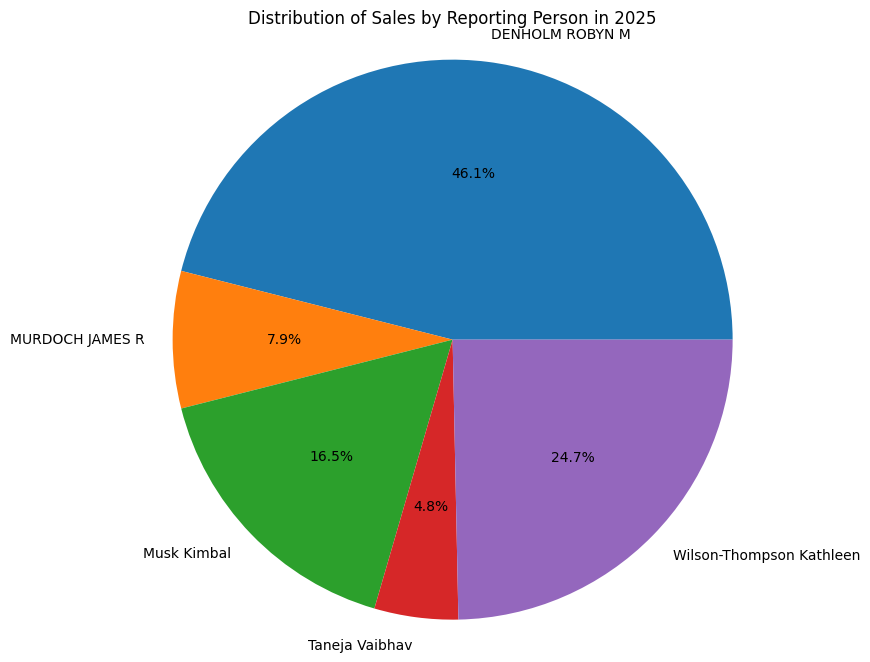

In [20]:
# Filter for sells
sells_by_person = transactions_2025[transactions_2025.transaction_code == "S"]

# Group by reporting person and sum dollar values
person_totals = sells_by_person.groupby('reporting_person')['dollar_value'].sum()

# Create pie chart
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plt.pie(person_totals.values, labels=person_totals.index, autopct='%1.1f%%')
plt.title('Distribution of Sales by Reporting Person in 2025')
plt.axis('equal')
plt.show()
